In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, roc_curve
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv('bird_data.csv')
data.head()# Dropping unneccesary columns

,birdSound,sound_median,sound_mean,sound_std,chroma_stft_median,chroma_stft_mean,chroma_stft_std,rms_median,rms_mean,rms_std,...,mfcc_median18,mfcc_mean18,mfcc_std18,mfcc_median19,mfcc_mean19,mfcc_std19,mfcc_median20,mfcc_mean20,mfcc_std20,label
0,351230.mp3,0.000000e+00,-6.142107e-05,0.012161,0.596200,0.529412,0.342621,0.002863,0.005909,0.010629,...,6.046153,5.956075,5.962350,9.087703,9.135355,6.044546,8.104885,8.139686,5.670450,Red_crossbill
1,365803.mp3,3.176906e-07,-8.101284e-09,0.035807,0.391162,0.424132,0.311685,0.006933,0.022807,0.027601,...,2.963391,3.257329,6.337379,9.306860,9.189724,6.112482,-1.249606,-1.692509,5.749753,Red_crossbill
2,364248.mp3,0.000000e+00,7.826290e-08,0.023321,0.500404,0.506566,0.294321,0.003329,0.010292,0.020916,...,6.002545,6.172754,4.921592,-2.660161,-2.276274,3.988553,5.196372,5.018038,4.176434,Red_crossbill
3,512152.mp3,2.295497e-05,4.515932e-05,0.009364,0.831979,0.799930,0.171446,0.008113,0.008701,0.003462,...,8.155019,7.944302,4.671725,6.125269,6.154128,4.302269,8.689074,8.654900,4.420681,Red_crossbill
4,365803.mp3,3.176906e-07,-8.101284e-09,0.035807,0.391162,0.424132,0.311685,0.006933,0.022807,0.027601,...,2.963391,3.257329,6.337379,9.306860,9.189724,6.112482,-1.249606,-1.692509,5.749753,Red_crossbill


In [3]:
data.shape

(9370, 83)

In [6]:
import seaborn as sns

In [8]:
bird_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(bird_list)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], y, test_size=0.20, stratify=y)

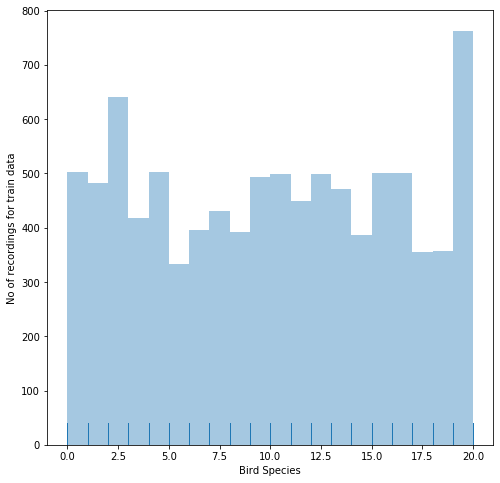

In [21]:
plt.figure(figsize=(8,8))
sns.distplot(y, kde=False, rug=True);
plt.xlabel("Bird Species")
plt.ylabel("No of recordings for train data");

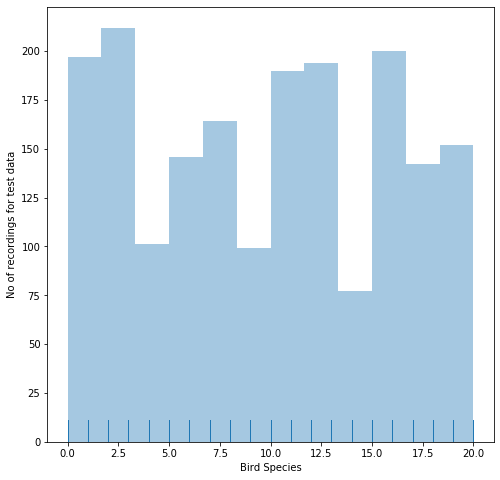

In [22]:
plt.figure(figsize=(8,8))
sns.distplot(y_test, kde=False, rug=True);
plt.xlabel("Bird Species")
plt.ylabel("No of recordings for test data");

In [28]:
X_test["label"] = encoder.inverse_transform(y_test)
X_train["label"] = encoder.inverse_transform(y_train)

In [29]:
X_test.to_csv('test_bird_data.csv', index=False)
X_train.to_csv('train_bird_data.csv', index=False)

In [30]:
X_train.drop(columns=['birdSound', 'label'], inplace=True)
X_test.drop(columns=['birdSound', 'label'], inplace=True)

In [31]:
poly = PolynomialFeatures(include_bias=False, interaction_only=True)

In [32]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [33]:
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(data.iloc[:, :-1].columns))
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly.get_feature_names(data.iloc[:, :-1].columns))

In [34]:
len(X_train_poly_df.columns)

3321

In [35]:
X_train_ar = np.array(X_train_poly_df, dtype = float)
X_test_ar = np.array(X_test_poly_df, dtype = float)

In [36]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_ar)#Dividing data into training and Testing set
X_test_sc = scaler.transform(X_test_ar)

In [37]:
pd.Series(y).value_counts()

2     640
4     503
0     502
16    501
15    500
12    499
10    498
9     494
1     483
13    471
19    457
11    450
7     430
3     418
6     395
8     392
14    386
18    357
17    355
5     333
20    306
dtype: int64

In [38]:
model = Sequential()
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(21, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
classifier = model.fit(X_train_sc,
                    y_train,
                    epochs=200,
                    batch_size=500,
                    validation_data=(X_test_sc,y_test),
                    verbose=0)

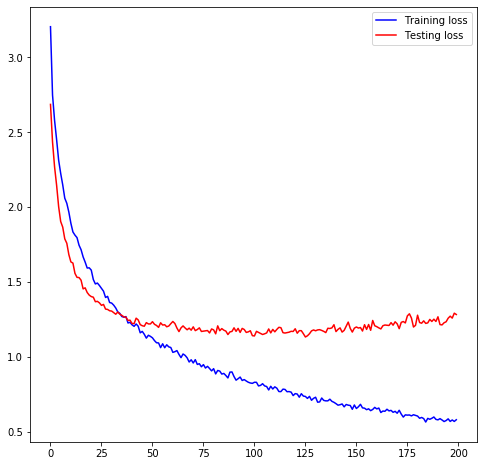

In [40]:
train_loss = classifier.history['loss']
test_loss = classifier.history['val_loss']
plt.figure(figsize=(8, 8))
plt.plot(train_loss, label='Training loss', color='blue')
plt.plot(test_loss, label='Testing loss', color='red')
plt.legend();

In [41]:
y_test

array([ 8, 18, 20, ..., 17, 20, 17])

In [42]:
model.predict_classes(X_test_sc)

array([ 5, 18, 20, ..., 17,  3, 17])

In [43]:
j = y_test == model.predict_classes(X_test_sc)

In [44]:
correct = 0
incorrect = 0 
for i in j:
    if i :
        correct += 1
    else:
        incorrect += 1

In [45]:
correct

1380

In [46]:
incorrect

494

In [47]:
y_test.shape

(1874,)

In [48]:
(correct / (correct+incorrect))*100

73.63927427961579

In [49]:
model.save("21BirdsModel.h5")

In [50]:
model_load = load_model('21BirdsModel.h5')

In [51]:
y_pred_2 = model_load.predict_classes(X_test_sc)

In [52]:
target_names = encoder.inverse_transform(pd.Series(y_test).sort_values().unique())

In [53]:
print(classification_report(y_test, model_load.predict_classes(X_test_sc), target_names=target_names))

                          precision    recall  f1-score   support

       Black-headed_gull       0.78      0.77      0.77       100
Brown-crested_flycatcher       0.79      0.67      0.73        97
            Canada_goose       0.88      0.88      0.88       128
            Common_crane       0.86      0.82      0.84        84
            Common_raven       0.75      0.73      0.74       101
             Common_tern       0.72      0.70      0.71        67
   Curve-billed_thrasher       0.85      0.65      0.73        79
         Dark-eyed_junco       0.50      0.70      0.59        86
 Dusky-capped_flycatcher       0.54      0.64      0.59        78
  Eurasian_collared-dove       0.87      0.85      0.86        99
        Eurasian_skylark       0.60      0.72      0.65       100
            Gray_wagtail       0.77      0.71      0.74        90
           House_sparrow       0.71      0.70      0.70       100
                 Mallard       0.72      0.83      0.77        94
         

In [55]:
X_test = pd.read_csv('test_bird_data.csv')

In [59]:
pred_vals = encoder.inverse_transform(model_load.predict_classes(X_test_sc))

In [60]:
X_test["preds"] = pred_vals

In [62]:
X_test = X_test[X_test["preds"] == X_test["label"]]

In [63]:
X_test.to_csv('test_bird_data.csv', index=False)